# The Geometry of Superposition

In [146]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

from model import Model, learning

## Uniform Superposition

In [97]:
n = 400
m = 30

num = 10000

S =  torch.logspace(start=0, end=-4, steps=100)
S = S.reshape(len(S),-1)

n_instances = len(S)

X = np.random.rand(num, n)
importances = torch.tensor([1 for k in range(n)])

In [98]:
model = Model(n, m, S,  n_instances)
no_linear_model = learning(model, X, importances, n, 10000)

100%|█████████████████████████████████████| 10000/10000 [11:53<00:00, 14.02it/s]


In [202]:
def paint_(model, m, S):
    y = m / torch.norm(model.W, p='fro', dim=[1,2]) ** 2
    plt.plot(np.linspace(1, 10, len(S)), y.detach().numpy())
    plt.xticks(np.arange(0, 11, step=1))
    plt.xscale('log')
    plt.show()
    #plt.grid()

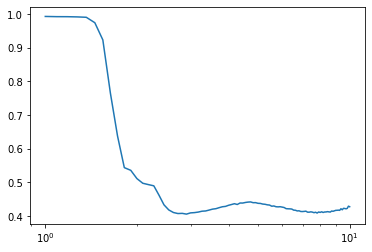

In [203]:
paint_(no_linear_model, m, S)

In [303]:
def count_dimensionality(model, S, n):
    
    W = model.W.detach()
    W_norm = torch.linalg.norm(W, 2, dim=-1, keepdim=True)
    #print(W_norm.shape)
    interference = torch.einsum('ifh,igh->ifg', W / (1e-5 + W_norm), W)
    interference[:, torch.arange(n), torch.arange(n)] = 0
    polysemanticity = torch.linalg.norm(interference, dim=-1)
    
    #print( W_norm.shape, polysemanticity.shape)
    x = np.linspace(1, 10, len(S))
    x = np.repeat(x, n)
    print(x.shape)
    print(W_norm.shape)
    D_tensor = ((W_norm.reshape(W_norm.shape[0], W_norm.shape[1]) ** 2 )/ (polysemanticity ** 2)).reshape(-1)
    print( D_tensor.shape)
    plt.scatter(x, D_tensor)
    plt.xscale('log')
    return D_tensor

(40000,)
torch.Size([100, 400, 1])
torch.Size([40000])


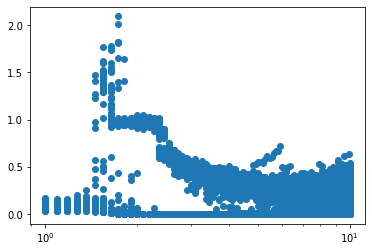

In [304]:
n = 400
S =  torch.logspace(start=0, end=-4, steps=100)
a = count_dimensionality(no_linear_model, S, n)

In [100]:
import plotly.graph_objects as go

In [107]:
@torch.no_grad()
def compute_dimensionality(W):
    norms = torch.linalg.norm(W, 2, dim=-1) 
    W_unit = W / torch.clamp(norms[:, :, None], 1e-6, float('inf'))

    interferences = (torch.einsum('eah,ebh->eab', W_unit, W)**2).sum(-1)

    dim_fracs = (norms**2/interferences)
    return dim_fracs.cpu()

In [109]:
dim_fracs = compute_dimensionality(no_linear_model[0].W)

In [110]:
fig = go.Figure()

density = no_linear_model[0].feature_probability[:, 0].cpu()
W = no_linear_model[0].W.detach()

for a,b in [(1,2), (2,3), (2,5), (2,6), (2,7)]:
    val = a/b
    fig.add_hline(val, line_color="purple", opacity=0.2, annotation=dict(text=f"{a}/{b}"))

for a,b in [(5,6), (4,5), (3,4), (3,8), (3,12), (3,20)]:
    val = a/b
    fig.add_hline(val, line_color="blue", opacity=0.2, annotation=dict(text=f"{a}/{b}", x=0.05))

for i in range(len(W)):
    fracs_ = dim_fracs[i]
    N = fracs_.shape[0]
    xs = 1/density
    if i!= len(W)-1:
        dx = xs[i+1]-xs[i]
    fig.add_trace(
        go.Scatter(
            x=1/density[i]*np.ones(N)+dx*np.random.uniform(-0.1,0.1,N),
            y=fracs_,
            marker=dict(
                color='black',
                size=1,
                opacity=0.5,
            ),
            mode='markers',
        )
    )

fig.update_xaxes(
    type='log', 
    title='1/(1-S)',
    showgrid=False,
)
fig.update_yaxes(
    showgrid=False
)
fig.update_layout(showlegend=False)

## Aside: Polytopes and Low-Rank Matrices

In [305]:
n = 100
m = 3

num = 10000

S =  torch.tensor([0.4])
S = S.reshape(len(S),-1)

n_instances = len(S)

X = np.random.rand(num, n)
importances = torch.tensor([1 for k in range(n)])

In [306]:
model_aside = Model(n, m, S,  n_instances)
no_linear_model_aside = learning(model_aside, X, importances, n, 10000)

100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1502.64it/s]


In [307]:
no_linear_model_aside.W[0].T @ no_linear_model_aside.W[0]

tensor([[ 1.5464,  0.4037, -0.1837],
        [ 0.4037,  1.6232,  0.1818],
        [-0.1837,  0.1818,  1.3472]], grad_fn=<MmBackward0>)

In [142]:
n = 200
m = 20

num = 10000
n_instances = 20

#S = torch.cat((torch.linspace(10, 1.1, n_instances // 2), torch.linspace(1, 0.1, n_instances // 2)))[:, None]
#S = S.reshape(len(S),-1)
S = (20 ** -torch.linspace(0, 1, n_instances))[:, None]

X = np.random.rand(num, n)
importances = torch.tensor([1 for k in range(n)])




In [134]:
S.shape

torch.Size([20, 1])

In [135]:
model_aside = Model(n, m, S,  n_instances)
no_linear_model_aside, error = learning(model_aside, X, importances, n, 10000, lr=0.001, batch_size=1024)

100%|█████████████████████████████████████| 10000/10000 [11:06<00:00, 15.00it/s]


In [136]:
error.shape

torch.Size([1024, 20, 200])

In [137]:
error.shape

torch.Size([1024, 20, 200])

In [138]:
def paint_loss_curve_crossover(error, S):
    losses = []
    for i in range(error.shape[1]):
        losses.append(error[:,i].mean().sum().item())
    fig, ax = plt.subplots()
    ax.plot(np.arange(len(S)), losses)
    
    #plt.xticks(S.reshape(-1).numpy()[::-1])
    ax.set(xticks=[0, 50, 100], xticklabels=[0.1, 1, 10])

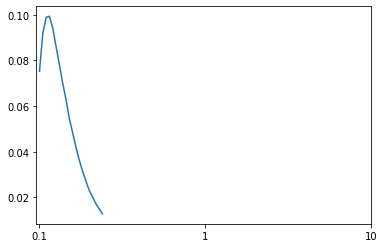

In [139]:
paint_loss_curve_crossover(error, S)

In [141]:
import plotly.express as px
fig = px.line(
    x=1/no_linear_model_aside.feature_probability[:, 0].cpu(),
    y=(m/(torch.linalg.matrix_norm(no_linear_model_aside.W.detach(), 'fro')**2)).cpu(),
    
    log_x=True,
    markers=True,
)
fig.update_xaxes(title="1/(1-S)")
fig.update_yaxes(title=f"m/||W||_F^2")

In [143]:
n = 400
m = 30

num = 10000
n_instances = 20

#S = torch.cat((torch.linspace(10, 1.1, n_instances // 2), torch.linspace(1, 0.1, n_instances // 2)))[:, None]
#S = S.reshape(len(S),-1)
S = (20 ** -torch.linspace(0, 1, n_instances))[:, None]

X = np.random.rand(num, n)
importances = torch.tensor([1 for k in range(n)])


In [144]:
model_aside30_400 = Model(n, m, S,  n_instances)
no_linear_model_aside30_400 , error = learning(model_aside30_400 , X, importances, n, 10000, lr=0.001, batch_size=1024)

100%|███████████████████████████████████| 10000/10000 [6:37:40<00:00,  2.39s/it]


In [145]:
import plotly.express as px
fig = px.line(
    x=1/no_linear_model_aside30_400.feature_probability[:, 0].cpu(),
    y=(m/(torch.linalg.matrix_norm(no_linear_model_aside30_400.W.detach(), 'fro')**2)).cpu(),
    
    log_x=True,
    markers=True,
)
fig.update_xaxes(title="1/(1-S)")
fig.update_yaxes(title=f"m/||W||_F^2")